In [1]:
#ideas for importing data:
#1. get data in batches: export to a list, export list to a csv, import csv for each new run - do data preprocessing
#2. get data in batches, process each batch, export to a csv, import csv with specified datatypes
#3. how big is a "big" dataset? whats the general limit for what i can export to work with on my computer?
#4. multithreading vs. multiprocessing?
#5. export data to a database? SQLalchemy
#6. work directly in colab, then download and export to github?

## Import dataset, reduce memory

In [2]:
#options:
#1. download locally, wait for however long it takes, large = when it stops fitting in ram
#mem = temp working space, fast to access but can't store much, might be erased; disk = long term storage
#goal = get something done quickly
#embarrassingly parallel problems: processes don't need to talk to each other 

#2. BQ: data stays in google servers, might have to pay eventually, if you need to do a lot of processing / really large datasets
#take the processed results 
#use api to query from BQ

#3. spark cluster on AWS

#keep raw data - quickly recover

#python stores each num as an obj; each obj has overhead involved (methods, value, ref count)
#numpy stores all of these values as one obj

In [3]:
import pandas as pd
import numpy as np
import requests
#python client for Socrata open data API
from sodapy import Socrata
import os
import seaborn as sns
from matplotlib import pyplot as plt
import sys
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import pygsheets

os.getcwd()
pd.options.display.max_columns=50

/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:
#define parameters for endpoint, dataset, and app token
data_url = 'data.cityofnewyork.us'
dataset = 'erm2-nwe9'
app_token = 'dM7DDeidbAmgtydtJVV1epbiU'

#sets up the connection, need application token to override throttling limits
#username and password only required for creating or modifying data
client = Socrata(data_url, app_token)
client.timeout = 6000

#count number of records in desired dataset
record_count = client.get(dataset, select='count(*)', where="created_date >='2019-01-01'")
record_count

[{'count': '3082555'}]

In [8]:
def get_data(chunk_size=100000, total_rows=500000):
    start = 0
    results=[]

    #paginate through dataset in sets of 10000 to get all records since 2019
    while True:
        print(start)
        results.extend(client.get(dataset,where="created_date >= '2019-01-01'", 
                                  limit=chunk_size, offset=start))
        start += chunk_size
        if start > total_rows:
            break
    return results

orig_results = get_data()
orig_df = pd.DataFrame(orig_results)
orig_df.to_csv('/Users/christinejiang/Documents/Python/data/311_data.csv', index=False)

0
100000
200000
300000
400000
500000


In [9]:
def get_mem_usage(df):
    dtypes = df.dtypes.astype(str).unique()
    total_mem = df.memory_usage().sum()/1024**2
    for dtype in dtypes:
        selected_dtype = df.select_dtypes(include=dtype)
        mean_usage_b = selected_dtype.memory_usage().mean()
        mean_usage_mb = mean_usage_b / 1024**2
        print('avg memory usage for {} columns: {:03.2f} MB'.format(dtype, mean_usage_mb))
    print(f'total memory usage: {total_mem:.2f}')
    
def new_memory_reduction(df):
    """improved version of memory reduction function. uses pd.to_numeric to downcast types;
    also considers whether there are few enough unique values to warrant use of category vs. object."""
    orig_size = df.memory_usage().sum()/1024**2
    dtypes = df.dtypes.astype(str).unique()
    converted_float = pd.DataFrame()
    converted_int = pd.DataFrame()
    converted_obj = pd.DataFrame()
    for dtype in dtypes:
        if 'float' in dtype:
            selected_float = df.select_dtypes(include='float')
            converted_float = selected_float.apply(pd.to_numeric, downcast='float')
            float_size = selected_float.memory_usage().sum()/1024**2
            converted_float_size = converted_float.memory_usage().sum()/1024**2
            print(f'floats: {float_size:.2f} reduced to {converted_float_size:.2f} MB')
        if 'int' in dtype:
            selected_int = df.select_dtypes(include='integer')
            converted_int = selected_int.apply(pd.to_numeric, downcast='integer')
            int_size = selected_int.memory_usage().sum()/1024**2
            converted_int_size = converted_int.memory_usage().sum()/1024**2
            print(f'ints: {int_size:.2f} reduced to {converted_int_size:.2f} MB')
        if 'object' in dtype:
            selected_object = df.select_dtypes(include='object')
            obj_size = selected_object.memory_usage().sum()/1024**2
            for col in selected_object.columns:
                count = len(selected_object[col])
                unique = len(selected_object[col].astype(str).unique())
                if unique < count/2:
                    converted_obj[col] = selected_object[col].astype(str).astype('category')
                else:
                    converted_obj[col] = selected_object[col].astype(str)
            converted_obj_size = converted_obj.memory_usage().sum()/1024**2
            print(f'object: {obj_size:.2f} reduced to {converted_obj_size:.2f} MB')

    float_int = converted_float.join(converted_int)
    reduced_df = float_int.join(converted_obj)
    reduced_df = reduced_df[df.columns]
    reduced_size = reduced_df.memory_usage().sum()/1024**2
    print(f'final df: {orig_size:.2f} reduced to {reduced_size:.2f} MB, {(orig_size-reduced_size)/orig_size*100:.1f}% reduction')
    return reduced_df

In [10]:
#olddf - most dtypes are objects, some are ints and some are floats
#BUT olddf datatypes get changed inplace after running reduce_mem_usage! becomes mostly categorical
olddf = pd.read_csv('/Users/christinejiang/Documents/Python/data/311_data.csv')

#newdf - most dtypes are categorical, some ints and floats
newdf = new_memory_reduction(olddf)

/Users/christinejiang/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


ints: 4.58 reduced to 2.29 MB
object: 160.22 reduced to 96.35 MB
floats: 22.89 reduced to 11.44 MB
final df: 187.68 reduced to 110.08 MB, 41.3% reduction


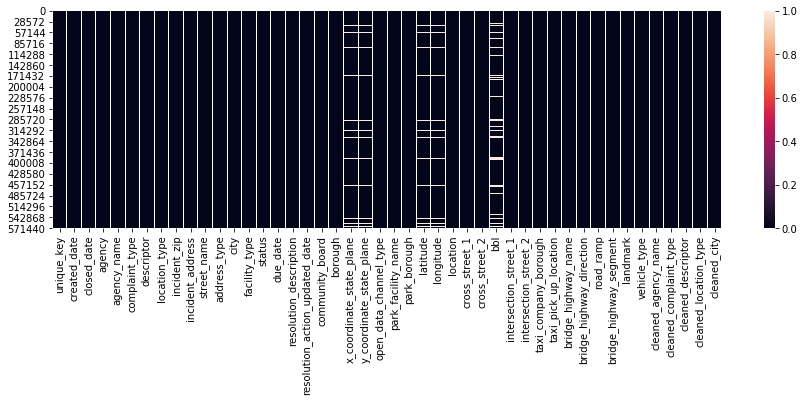

In [24]:
plt.rc('figure',figsize=(15,4))
sns.heatmap(newdf.isnull())

## Data Processing

In [12]:
def preprocess_df(df):
    '''drop columns that are mostly blank, create time-related columns from date columns'''
    cleandf = df.drop(['intersection_street_1',
               'intersection_street_2',
               'taxi_company_borough',
               'taxi_pick_up_location',
               'bridge_highway_name',
               'bridge_highway_direction',
               'road_ramp',
               'bridge_highway_segment',
               'landmark',
               'vehicle_type'], axis=1, inplace=False)

    for col in cleandf.columns:
        if 'date' in col:
            cleandf[col] = pd.to_datetime(cleandf[col])
            
    cleandf['created_year'] = [x.year for x in cleandf['created_date']]
    cleandf['created_month'] = [x.month for x in cleandf['created_date']]
    cleandf['created_day'] = [x.day for x in cleandf['created_date']]
    cleandf['created_hour'] = [x.hour for x in cleandf['created_date']]
    cleandf['closed_hour'] = [x.hour for x in cleandf['closed_date']]
    cleandf['time_to_close'] = cleandf['closed_date'] - cleandf['created_date']
    return cleandf

In [13]:
def export_col_values(workbook, df, columns):
    """for a list of columns, creates a new sheet for each column and exports unique values and their counts to that sheet"""
    for col in columns:
        value_counts = df[col].value_counts()
        counts_df = pd.DataFrame(value_counts).reset_index()
        try:
            worksheet = workbook.worksheet_by_title(col)
        except WorksheetNotFound:
            workbook.add_worksheet(col)
            worksheet = workbook.worksheet_by_title(col)
        worksheet.set_dataframe(counts_df, start='A1')
    print(f'{len(columns)} sets of column values exported.')
        
def get_valid_names(workbook, columns, start='D1'):
    """extracts the valid names manually entered by the user in column D of the workbook"""
    valid_names = {}
    for col in columns:
        worksheet = workbook.worksheet_by_title(col)
        valid_matrix = worksheet.get_values(start='D1', end='D100')
        valid_names[col] = [v[0] for v in valid_matrix]
    return valid_names

def fuzzy_match(value):
    """returns the best match for each column; fuzzy match score of < 90 will return 'Other'"""
    match = process.extract(query=value, choices=valid_names[col], limit=1)
    if match[0][1] < 90:
        return 'Other'
    else:
        return match[0][0]

In [14]:
#use pygsheets to connect to workbook where we will export unique column values
client = pygsheets.authorize(service_account_file='/Users/christinejiang/Documents/Python/data/client_secret.json')
workbook = client.open('311_data_cleaning')
columns = ['agency_name','complaint_type','descriptor','location_type','city']

#export unique column values and their counts
export_col_values(workbook, newdf, columns)
#get dictionary of lists with valid names for each column
valid_names = get_valid_names(workbook, columns, start='D1')

#fuzzy match each of the columns to the available values
for col in columns:
    newdf['cleaned_'+col] = newdf[col].apply(fuzzy_match)
    
processed_df = preprocess_df(newdf)

5 sets of column values exported.


In [16]:
processed_df['facility_type'].value_counts()

nan            435683
Precinct       141910
DSNY Garage     22053
School            354
Name: facility_type, dtype: int64